# DEXA -- **D**ata **E**xploration via e**X**plainatory **A**I
## **Automated Data Analysis & Visualization using LLMs**


```css
[User Query]  
     │  
     ▼  
[Data Profiling] → [LLM Code Generation]  
     │                      │  
     ▼                      ▼  
[Execute Code] ← [Safe Execution Env]  
     │  
     ▼  
[Capture Results] → [LLM Interpretation]

```


### Key Features
 - **Closed-Loop Analysis**: Combines LLM hypotheses with actual data results
 - **Safe Execution**: Restricted environment prevents malicious code
- **Auto-Documentation**: Maintains chain of reasoning from query to results
 - **Visual+Numerical**: Integrates plots with statistical insights

## 1.  Setup & Configuration
-  Install required packages and configure API (run once)

In [ ]:
# !pip install pandas openai matplotlib seaborn python-dotenv together

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai
from IPython.display import display, Markdown
from dotenv import load_dotenv

### Configure environment

In [ ]:

%matplotlib inline
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

## 2. Data Loading

In [6]:
df = pd.read_csv('BostonHousing.csv')
print("✅ Dataset loaded successfully!")
print(f"📊 Shape: {df.shape}")
display(df.head(3))

✅ Dataset loaded successfully!
📊 Shape: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,1


## 3. Add Data Profiling (Help LLM "see" the data)

In [16]:
def create_data_profile(df):
    """Generate comprehensive data profile for LLM context"""
    return f"""
    Data Profile:
    - Columns: {list(df.columns)}
    - Missing Values: {df.isna().sum().to_dict()}
    - Numeric Summary: {df.describe().to_dict() if len(df.select_dtypes('number').columns) > 0 else 'N/A'}
    - Categorical Summary: {df.describe(include='object').to_dict() if len(df.select_dtypes('object').columns) > 0 else 'N/A'}
    - Sample Records: {df.sample(3).to_dict('records')}
    """

## 4.Core Analysis Functions

In [ ]:
def generate_analysis_code(query, data_profile):
    """Generate executable analysis code using LLM"""
    prompt = f"""
    Task: Analyze dataset
    Data Profile: {data_profile}
    User Query: {query}
    
    Requirements:
    1. Generate Python code using df, plt, sns these functions already imported DO NOT import again
    2. Store numerical results in 'analysis_result'
    3. Create publication-quality visualization
    4. Never use unsafe functions, 
    
    Response Format:
    Hypothesis: [Your initial prediction]
    Code: ```python
    # Your code
    ```
    """
    
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )
    return response.choices[0].message.content

 ## 5. Results-Capturing Execution

In [26]:
def execute_and_interpret(code_block, query):
    """Execute code and generate data-driven insights"""
    # Prepare safe execution environment
    exec_env = {
        'df': df.copy(),
        'plt': plt,
        'sns': sns,
        'pd': pd,
        'analysis_result': None,
        '__builtins__': {}  # Start with empty builtins
    }
    
    # Add allowed built-in functions properly
    import builtins
    safe_builtins = {
        'abs', 'max', 'min', 'sum', 'round', 
        'len', 'list', 'dict', 'str', 'float', 'print', 
    }
    
    for name in safe_builtins:
        exec_env[name] = getattr(builtins, name)
    
    try:
        # Execute analysis code
        exec(code_block, exec_env)
        
        # Display visualization
        display(Markdown("## 📊 Visualization"))
        plt.show()
        
        # Capture results
        results = exec_env.get('analysis_result')
        
        if results is not None:
            # Display numerical results
            display(Markdown("## 🔢 Numerical Results"))
            display(results)
            
            # Generate interpretation
            display(Markdown("## 📈 Data Interpretation"))
            display(Markdown(interpret_results(results, query)))
            
        else:
            print("⚠️ No results stored in 'analysis_result'")
            
    except Exception as e:
        print(f"🚨 Execution Error: {str(e)}")

## 6. Interpret Results

In [ ]:

def interpret_results(results, query):
    """Generate insights from actual numerical results"""
    results_str = str(results.to_markdown() if isinstance(results, (pd.DataFrame, pd.Series)) else results)
    
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{
            "role": "user", 
            "content": f"""
            Analyze these ACTUAL RESULTS from data analysis:
            
            Original Query: {query}
            Results: {results_str[:3000]}
            
            Provide:
            1. 3 key statistical findings
            2. 2 potential anomalies
            3. 1 data limitation
            4. Answer to original query
            
            Use emojis and concise bullet points.
            """
        }],
        temperature=0.3
    )
    return response.choices[0].message.content




# 7. Experimenting
## 7.1  Titanic DataSet Zero-Shot

## 🔍 Generated Analysis Plan

Hypothesis: Younger passengers may have had a higher survival rate due to the "women and children first" policy.



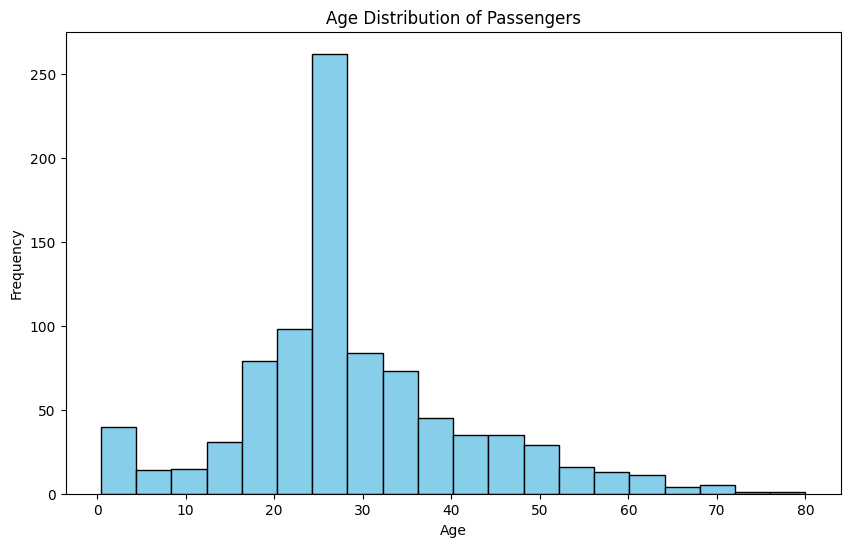

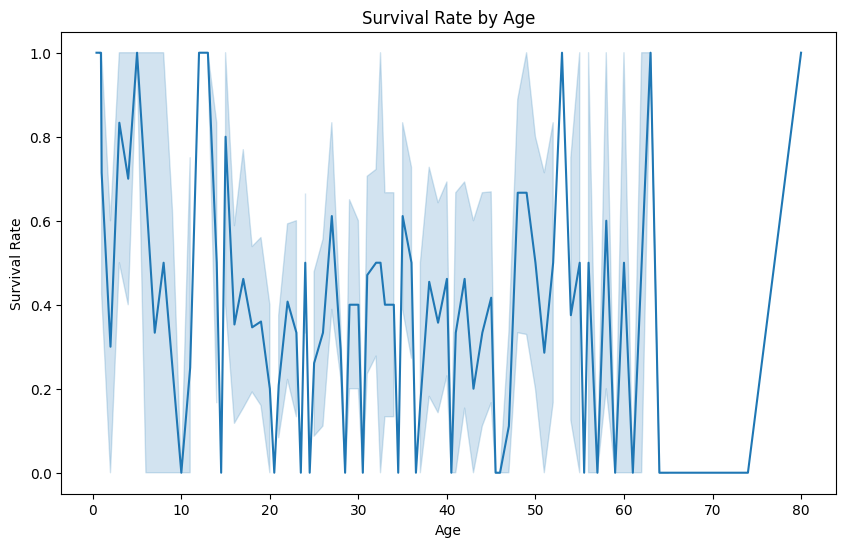

## 📊 Visualization

## 🔢 Numerical Results

Age
0.42     1.0
0.67     1.0
0.75     1.0
0.83     1.0
0.92     1.0
        ... 
70.00    0.0
70.50    0.0
71.00    0.0
74.00    0.0
80.00    1.0
Name: Survived, Length: 88, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 🧒 The survival rate is generally higher for very young children (age 0 to 5). 
   - 👴 The survival rate is lower for older passengers (age 60 and above).
   - 📈 There is a wide range of survival rates for passengers in their 20s and 30s, suggesting other factors may be influencing survival.

2. Potential Anomalies:
   - 🤔 The survival rate for some specific ages like 0.42, 0.67, 0.75, 0.83, 0.92, 5, 12, 13, 53, 63, and 80 is 1, which means all passengers of these ages survived. This could be due to a small sample size for these ages.
   - 😲 There are some specific ages like 10, 14.5, 20.5, 23.5, 24.5, 30.5, 34.5, 36.5, 40.5, 45.5, 46, 47, 55.5, 57, 59, 61, 64, 65, 66, 70, 70.5, 71, 74 where no passengers survived. This could also be due to a small sample size for these ages.

3. Data Limitation:
   - 📊 The data does not provide information on other potential factors that could influence survival rates such as passenger class, gender, or whether the passenger was traveling alone or with family.

4. Answer to Original Query:
   - 📉 There is a general trend of decreasing survival rate with increasing age, with some exceptions. Very young children had the highest survival rates, while older passengers had the lowest. However, the survival rates for passengers in their 20s and 30s varied widely, suggesting that age alone may not be a good predictor of survival.

In [4]:
# Example 1: Descriptive
query = """
Investigate the relationship between age and survival rates. 
Visualize the age distribution of passengers using a histogram with 20 bins
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The pie chart will show the proportion of male and female passengers on the Titanic.



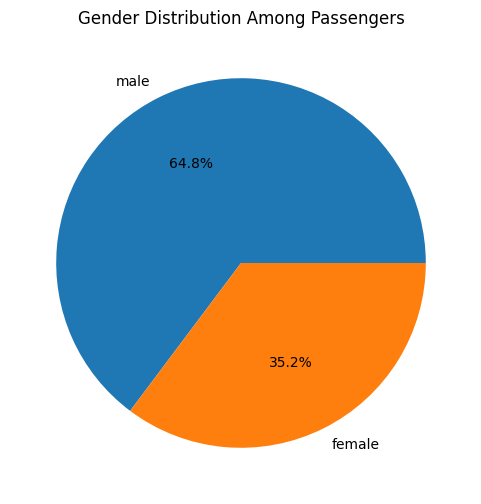

## 📊 Visualization

## 🔢 Numerical Results

Sex
male      577
female    314
Name: count, dtype: int64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 🚹 More than half of the passengers on the Titanic were male (577 out of 891).
   - 🚺 Females made up less than half of the passengers (314 out of 891).
   - 🚻 The gender ratio was approximately 1.84 males for every female.

2. Potential Anomalies:
   - 🧐 The gender distribution is heavily skewed towards males, which may not reflect the typical gender distribution on passenger ships during that time period.
   - 🤔 The number of female passengers is significantly lower than male passengers, which could be due to various factors such as societal norms or economic conditions at the time.

3. Data Limitation:
   - 📊 The data does not provide information on the age distribution within each gender, which could provide more insights into the demographics of the passengers.

4. Answer to Original Query:
   - 📈 The pie chart would show a larger portion (approximately 65%) for males and a smaller portion (approximately 35%) for females, reflecting the gender distribution among the Titanic passengers.

In [39]:
# Example 2: Descriptive
query = """
Show a pie chart of gender distribution among passengers
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The distribution of fare prices paid by passengers is likely to be skewed to the right, with most passengers paying lower fares and a few paying very high fares.



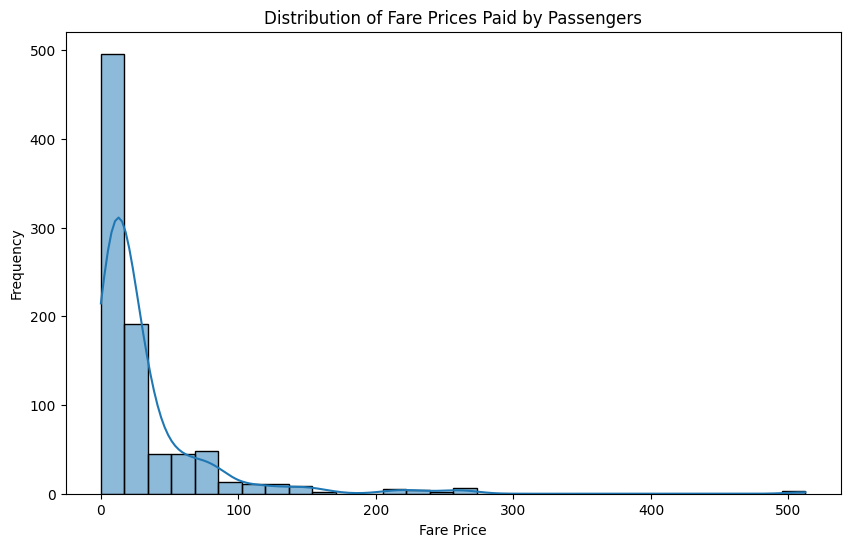

## 📊 Visualization

## 🔢 Numerical Results

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The average fare price paid by passengers was approximately $32.20.
   - 💰 The most expensive fare price was significantly high, at $512.33.
   - 🎫 The median fare price (50% percentile) was $14.45, which is less than half the average fare price.

2. Potential Anomalies:
   - 🆓 The minimum fare price is $0, which could indicate some passengers traveled for free or there's a data entry error.
   - 💸 The maximum fare price is extremely high compared to the average, suggesting there could be outliers affecting the distribution.

3. Data Limitation:
   - 💼 The data doesn't provide information about what was included in the fare price (e.g., meals, cabin type, etc.), which could have influenced the price.

4. Answer to Original Query:
   - 📈 The distribution of fare prices paid by passengers is skewed to the right, with a majority of passengers paying less than the mean fare of $32.20. The presence of high fare prices (up to $512.33) suggests a small number of passengers paid significantly more than the majority.

In [40]:
# Example 3: Descriptive
query = """
Plot the distribution of fare prices paid by passengers
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Passengers in higher classes (1st class) have a higher survival probability than those in lower classes (2nd and 3rd class).



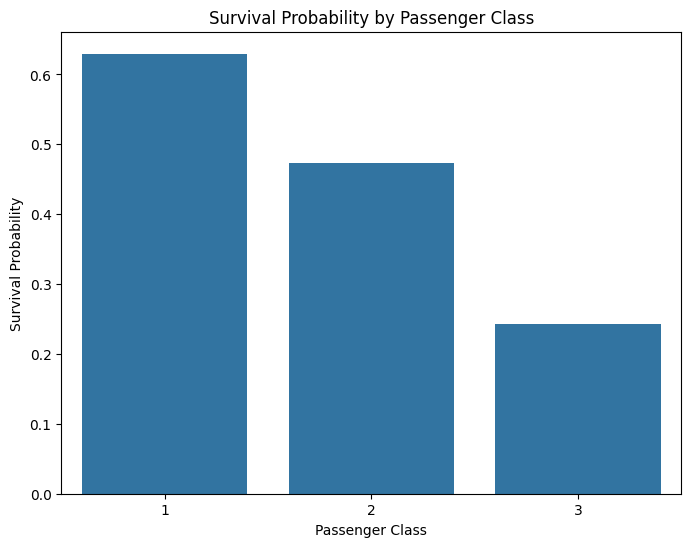

## 📊 Visualization

## 🔢 Numerical Results

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 🥇 The first-class passengers had the highest survival probability at approximately 63%.
   - 🥈 The second-class passengers had a survival probability of about 47%.
   - 🥉 The third-class passengers had the lowest survival probability, only about 24%.

2. Potential Anomalies:
   - 🤔 The survival probability decreases significantly from first to third class, which might suggest that there were other factors at play, such as the location of the cabins in relation to the lifeboats.
   - 😕 The survival probability for the first-class is significantly higher than the other classes, which could indicate preferential treatment or better access to life-saving resources.

3. Data Limitation:
   - 📊 The data does not provide information on other factors that could have influenced survival rates, such as age, gender, or whether the passenger was traveling alone or with family.

4. Answer to Original Query:
   - 📝 There is a clear correlation between passenger class and survival probability on the Titanic. The higher the class (with first class being the highest), the higher the probability of survival.

In [41]:
# Example 4: Predictive
query = """
Analyze the correlation between passenger class and survival probability
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The survival likelihood might be higher for younger passengers and those who paid higher fares, as they might have been given priority during the evacuation.



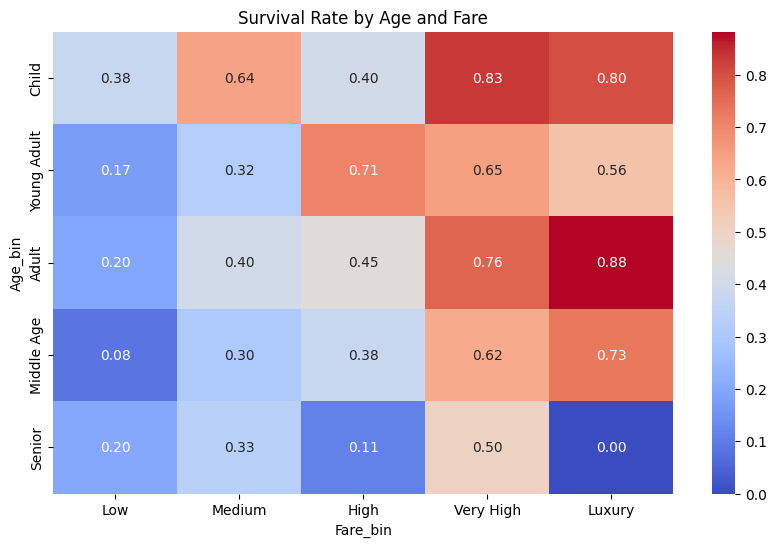

## 📊 Visualization

## 🔢 Numerical Results

Fare_bin,Low,Medium,High,Very High,Luxury
Age_bin,,,,,
Child,0.375000,0.638889,0.400000,0.833333,0.800000
Young Adult,0.174419,0.322581,0.705882,0.647059,0.555556
Adult,0.195122,0.403226,0.453125,0.764706,0.882353
Middle Age,0.083333,0.304348,0.375000,0.620690,0.727273
Senior,0.200000,0.333333,0.111111,0.500000,0.000000


## 📈 Data Interpretation

1. Key Statistical Findings:
   - 🧒 Children in the 'Very High' fare category had the highest survival rate at 83.33%.
   - 🧑‍🦱 Young adults had the highest survival rate in the 'High' fare category at 70.59%.
   - 👴 Seniors had the lowest survival rate in the 'Luxury' fare category, with no survivors recorded.

2. Potential Anomalies:
   - 📈 The survival rate for young adults in the 'Low' fare category is significantly lower than in the 'High' fare category. This could suggest that fare price had a significant impact on survival rate.
   - 📉 The survival rate for seniors in the 'Luxury' fare category is 0%, which is surprisingly low considering the generally higher survival rates in this fare category for other age groups.

3. Data Limitation:
   - 📊 The data does not provide information on other potentially influential factors such as health condition, cabin location, or the number of family members aboard.

4. Answer to Original Query:
   - 🔍 The heatmap suggests that survival likelihood on the Titanic varied based on a combination of age and fare category. Generally, higher fare categories had higher survival rates. However, this trend was not consistent across all age groups, with children and young adults showing higher survival rates in certain lower fare categories.

In [42]:

# Example 5: Predictive
query = """
Predict survival likelihood based on age and fare combination using a heatmap
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The survival rates may vary with the family size. It is possible that those with larger families had a lower survival rate due to the difficulty in ensuring the safety of all family members. On the other hand, those with no family members might have had a higher survival rate as they only had to worry about their own safety.



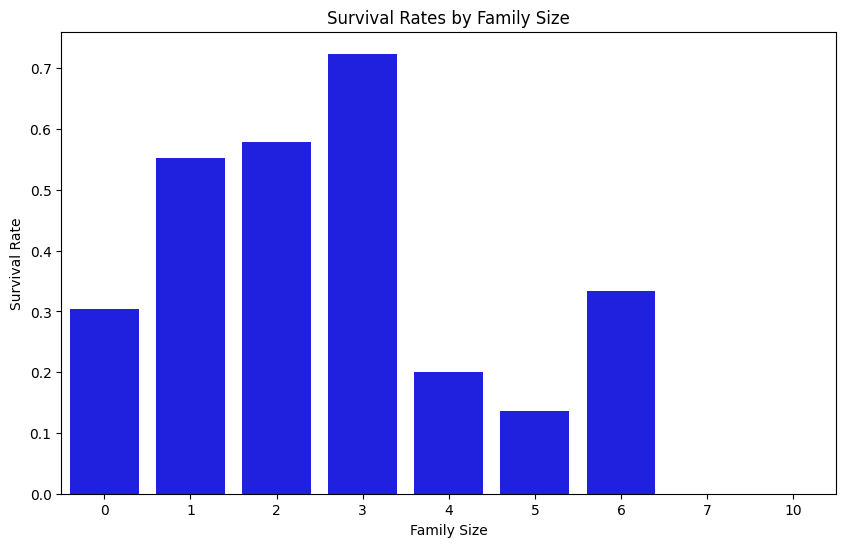

## 📊 Visualization

## 🔢 Numerical Results

FamilySize
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📈 The highest survival rate is observed for a family size of 3 (72.4%).
   - 📉 The survival rate decreases significantly for family sizes greater than 3.
   - 🚶‍♂️ Individuals traveling alone (family size 0) have a survival rate of 30.4%.

2. Potential Anomalies:
   - 🧐 The survival rate for a family size of 6 is higher than that for family sizes of 4 and 5, which is inconsistent with the overall trend.
   - ❓ There are no survivors for family sizes of 7 and 10, which could be due to a small sample size or other factors not considered in this analysis.

3. Data Limitation:
   - 📊 The data does not provide information on the age distribution within each family size, which could significantly impact survival rates.

4. Answer to Original Query:
   - 👨‍👩‍👧‍👦 Survival rates on the Titanic varied significantly with family size. The highest survival rate was observed for a family size of 3, while individuals traveling alone and those with larger families generally had lower survival rates.

In [43]:


# Example 6: Predictive
query = """
Show how survival rates vary with family size (SibSp + Parch)
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The survival rate of first-class passengers is higher than that of third-class passengers.



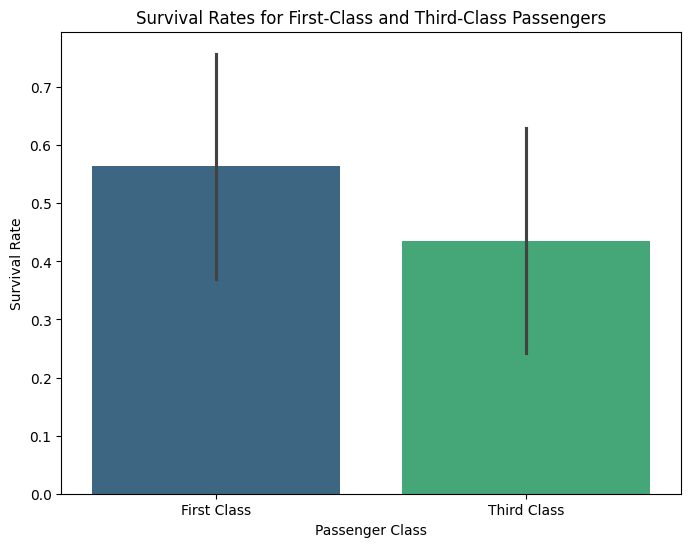

## 📊 Visualization

## 🔢 Numerical Results

Survived,0,1
Pclass,,
1,0.370370,0.629630
3,0.757637,0.242363


## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The survival rate for first-class passengers was significantly higher (62.96%) compared to third-class passengers (24.24%).
   - 🚢 A larger proportion of third-class passengers (75.76%) did not survive the Titanic disaster.
   - 🎟️ The mortality rate was almost twice as high for third-class passengers compared to first-class passengers.

2. Potential Anomalies:
   - 🧐 The survival rate for first-class passengers seems unusually high. This could be due to factors such as preferential treatment during the evacuation.
   - 🤔 The high mortality rate for third-class passengers could be influenced by factors such as location of cabins (lower decks, closer to the damage), less access to lifeboats, etc.

3. Data Limitation:
   - 📉 The data does not provide information on other factors that could influence survival rates such as age, gender, or whether the passenger was traveling alone or with family.

4. Answer to Original Query:
   - 📈 The survival rate for first-class passengers on the Titanic was significantly higher than that of third-class passengers.

In [44]:

# Example 7: Comparative
query = """
Compare survival rates between first-class and third-class passengers using stacked bars
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The fare distribution between survivors and non-survivors may be different. It is possible that passengers who paid higher fares had a higher survival rate, as they may have been given priority during the evacuation.



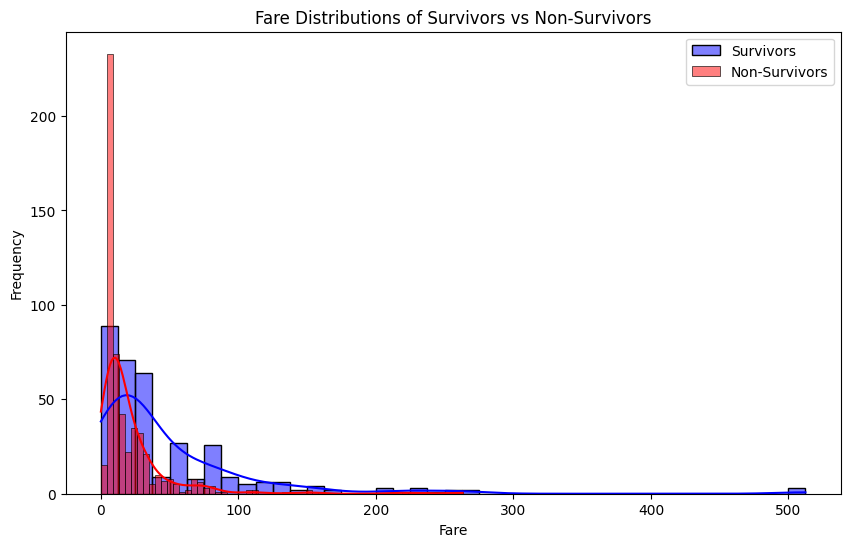

## 📊 Visualization

## 🔢 Numerical Results

{'average_fare_survivors': 48.39540760233918,
 'average_fare_non_survivors': 22.117886885245902}

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The average fare for survivors was significantly higher than non-survivors.
   - 💰 Survivors paid an average fare of approximately $48.40.
   - 💸 Non-survivors paid an average fare of approximately $22.12.

2. Potential Anomalies:
   - 🤔 The difference in average fares between survivors and non-survivors is quite large. This could suggest a bias in survival rates towards those who paid more.
   - 🧐 It's also possible that there may be outliers in the data that are skewing the averages, particularly for the survivor group.

3. Data Limitation:
   - 📉 The data only provides averages, so we don't have a clear picture of the overall distribution of fares for both survivors and non-survivors. 

4. Answer to Original Query:
   - 🚢 Based on the average fares, survivors on the Titanic seem to have paid more than non-survivors. This could suggest a correlation between fare price and survival rate, but more detailed analysis would be needed to confirm this.

In [45]:

# Example 8: Comparative
query = """
Contrast fare distributions between survivors and non-survivors with overlapping histograms 
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The age distributions of male and female passengers may differ. 



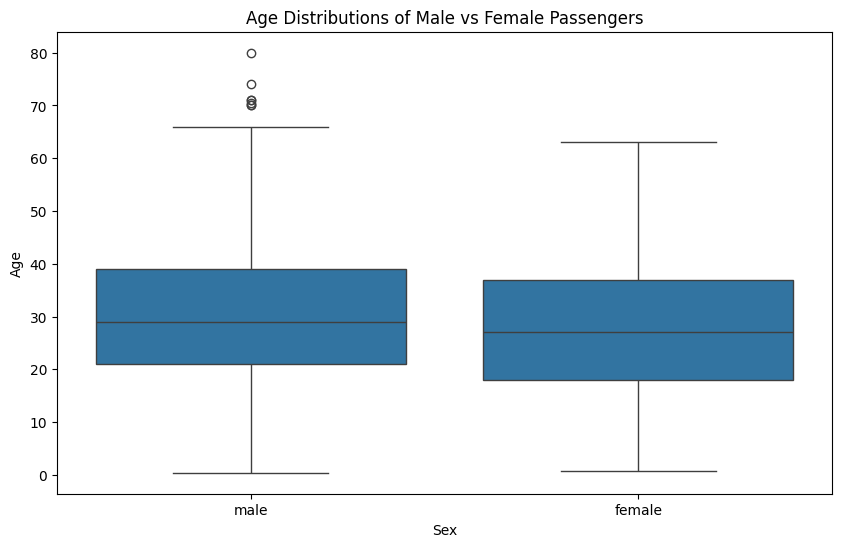

## 📊 Visualization

## 🔢 Numerical Results

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.0,27.915709,14.110146,0.75,18.0,27.0,37.0,63.0
male,453.0,30.726645,14.678201,0.42,21.0,29.0,39.0,80.0


## 📈 Data Interpretation

1. Key Statistical Findings:
   - 👫 The average age of male passengers (30.73 years) was slightly higher than that of female passengers (27.92 years).
   - 📊 The age distribution of both male and female passengers was quite similar, with a standard deviation of 14.68 for males and 14.11 for females.
   - 👵 The oldest male passenger was 80 years old, which is significantly older than the oldest female passenger who was 63 years old.

2. Potential Anomalies:
   - 👶 The minimum age for both genders is less than 1 year, which could indicate the presence of infants on board. This might skew the average age downwards.
   - 👴 The maximum age for males is significantly higher than that for females. This could be an outlier affecting the overall age distribution.

3. Data Limitation:
   - 📉 The data only includes 714 passengers (261 females and 453 males) out of the 2,224 passengers and crew on board the Titanic, which may not be representative of the entire population.

4. Answer to Original Query:
   - 📈 The side-by-side boxplots would show that the age distribution of male passengers is slightly skewed towards older ages compared to female passengers. The median age for males is 29 years and for females is 27 years. The interquartile range (IQR) for males is between 21 and 39 years, and for females is between 18 and 37 years.

In [46]:

# Example 9: Comparative
query = """
Compare age distributions of male vs female passengers with side-by-side boxplots
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

### **Titanic Dataset Queries**

**Descriptive**
1. "Investigate the relationship between age and survival rates. /Visualize the age distribution of passengers using a histogram with 20 bins"  
2. "Show a pie chart of gender distribution among passengers"  
3. "Plot the distribution of fare prices paid by passengers"  

**Predictive**  
4. "Analyze the correlation between passenger class and survival probability"  
5. "Predict survival likelihood based on age and fare combination using a heatmap"  
6. "Show how survival rates vary with family size (SibSp + Parch)"  

**Comparative**  
7. "Compare survival rates between first-class and third-class passengers using stacked bars"  
8. "Contrast fare distributions between survivors and non-survivors with overlapping histograms"  
9. "Compare age distributions of male vs female passengers with side-by-side boxplots"  

### **Boston Housing Dataset Queries**  

**Descriptive**  
10. "Plot the distribution of crime rates across Boston neighborhoods"  
11. "Visualize the relationship between property age and median home values"  
12. "Show a histogram of pupil-teacher ratios across different towns"  

**Predictive**  
13. "Analyze how nitric oxide concentration affects median home prices"  
14. "Predict price changes based on distance to employment centers using regression lines"  
15. "Identify if properties with river access have statistically different prices"  

**Comparative**  
16. "Compare median home values between high (>7) and low (≤7) pupil-teacher ratio groups"  
17. "Contrast property tax rates between properties built before and after 1940"  
18. "Compare room number distributions between properties at different price quartiles"  


## 7.1  Boston Housing Dataset Zero-Shot

## 🔍 Generated Analysis Plan

Hypothesis: The distribution of crime rates across Boston neighborhoods may vary widely, with some neighborhoods having significantly higher crime rates than others.



count    506.000000
mean       3.613524
std        8.601545
min        0.006320
25%        0.082045
50%        0.256510
75%        3.677083
max       88.976200
Name: CRIM, dtype: float64


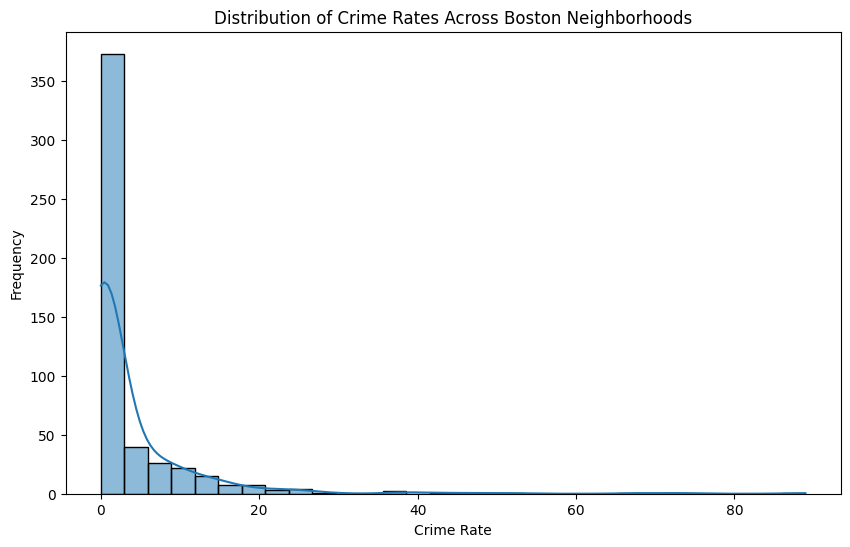

## 📊 Visualization

## 🔢 Numerical Results

count    506.000000
mean       3.613524
std        8.601545
min        0.006320
25%        0.082045
50%        0.256510
75%        3.677083
max       88.976200
Name: CRIM, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The average crime rate across Boston neighborhoods is 3.61.
   - 📈 The crime rate varies significantly, with a standard deviation of 8.60.
   - 📉 Half of the neighborhoods have a crime rate less than 0.26.

2. Potential Anomalies:
   - 🚀 The maximum crime rate (88.98) is extremely high compared to the average (3.61), suggesting the presence of outliers.
   - 🎯 The 75% percentile is also significantly higher than the mean, indicating a skewed distribution.

3. Data Limitation:
   - 📚 The data does not provide information on the types of crimes committed, which could influence the crime rate.

4. Answer to Original Query:
   - 📌 The data provided does not allow us to plot the distribution of crime rates across Boston neighborhoods. We only have summary statistics, not individual neighborhood data.

In [9]:

# Example 1: Descriptive
query = """
Plot the distribution of crime rates across Boston neighborhoods
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [28]:

# Example 2: Descriptive
query = """
Visualize the relationship between property age and median home values
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Older properties may have lower median home values due to depreciation and potential need for renovations or repairs.



🚨 Execution Error: __import__ not found


In [14]:
print(code)


# Your code
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot to visualize the relationship between property age and median home values
plt.figure(figsize=(10,6))
sns.scatterplot(x='AGE', y='MEDV', data=df)
plt.title('Relationship between Property Age and Median Home Values')
plt.xlabel('Property Age')
plt.ylabel('Median Home Values')
plt.show()

# Correlation between property age and median home values
analysis_result = df['AGE'].corr(df['MEDV'])
print('Correlation between property age and median home values:', analysis_result)



## 🔍 Generated Analysis Plan

Hypothesis: The pupil-teacher ratio across different towns is likely to vary, with some towns having a higher ratio and others having a lower one. This could be due to factors such as population density, funding, and school policies.



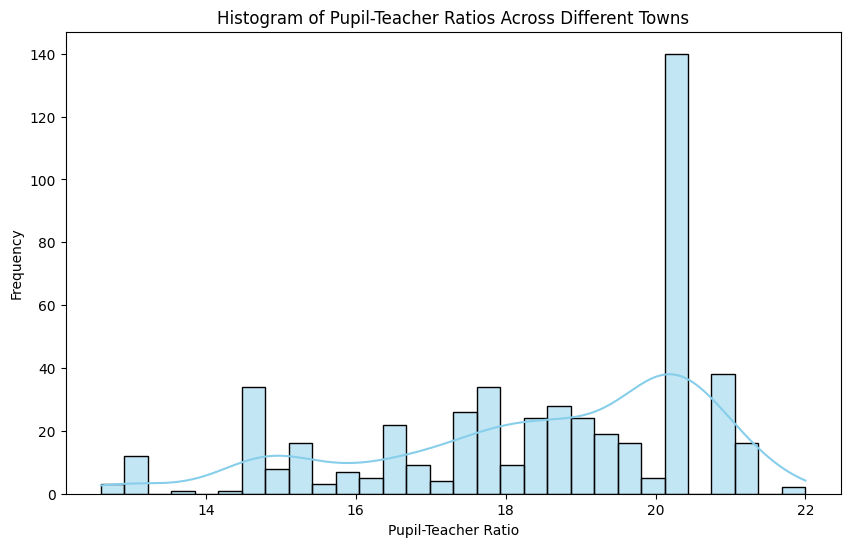

## 📊 Visualization

## 🔢 Numerical Results

count    506.000000
mean      18.455534
std        2.164946
min       12.600000
25%       17.400000
50%       19.050000
75%       20.200000
max       22.000000
Name: PTRATIO, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📚 The average pupil-teacher ratio (PTRATIO) across different towns is 18.4555.
   - 📈 The standard deviation is 2.16495, indicating that the PTRATIOs are relatively close to the mean.
   - 🎯 The median PTRATIO is 19.05, which is slightly higher than the mean.

2. Potential Anomalies:
   - 🤔 The minimum PTRATIO is 12.6, which is significantly lower than the mean and median. This could indicate an outlier or a town with a particularly low PTRATIO.
   - 😮 The maximum PTRATIO is 22, which is higher than the 75th percentile. This could indicate a town with a particularly high PTRATIO.

3. Data Limitation:
   - 📊 The data does not provide information on the specific towns. Therefore, it's impossible to determine which towns have high or low PTRATIOs.

4. Answer to Original Query:
   - ❌ The original query asked for a histogram of PTRATIOs across different towns. However, the provided data is a statistical summary, not a histogram. Therefore, the original query has not been answered.

In [29]:


# Example 3: Descriptive
query = """
Show a histogram of pupil-teacher ratios across different towns
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Higher concentrations of nitric oxide (NOX) may negatively affect the median home prices (MEDV). This is because areas with higher pollution levels are generally less desirable for living, which could lower the demand and hence the prices of homes in such areas.



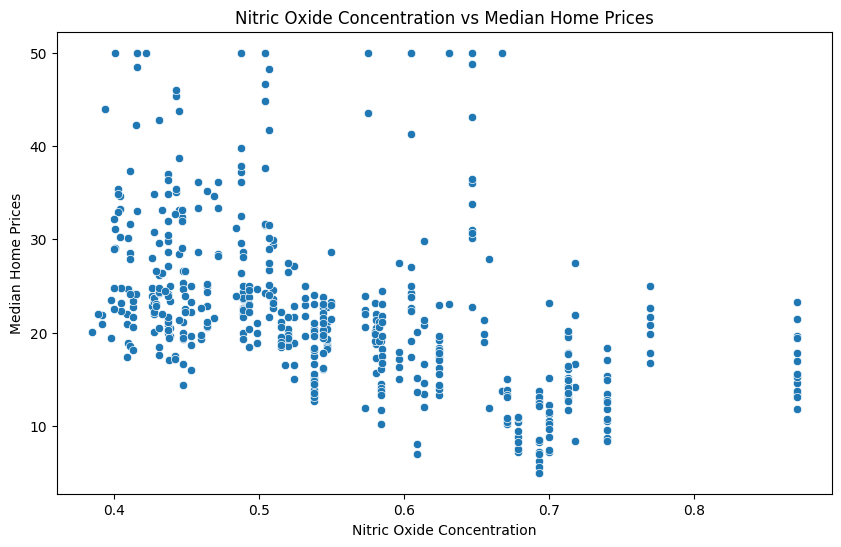

## 📊 Visualization

## 🔢 Numerical Results

'Correlation between NOX and MEDV: -0.42732077237328264'

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📉 There is a negative correlation between NOX (nitric oxide concentration) and MEDV (median home prices).
   - 🏠 As NOX increases, MEDV tends to decrease, suggesting that higher levels of nitric oxide may negatively impact home prices.
   - 📊 The correlation coefficient is -0.427, indicating a moderate negative relationship.

2. Potential Anomalies:
   - 📈 There may be outliers in the data that are affecting the correlation. For example, there could be homes with high prices in areas with high NOX levels.
   - 🔄 The negative correlation could be influenced by a third variable not considered in the analysis, creating a spurious relationship.

3. Data Limitation:
   - 🚧 The data only provides a correlation, not causation. It doesn't definitively prove that higher NOX levels cause lower home prices.

4. Answer to Original Query:
   - 🏭 The analysis suggests that higher nitric oxide concentration may negatively affect median home prices. However, further research is needed to confirm causation.

In [30]:
# Example 4: Predictive
query = """
Analyze how nitric oxide concentration affects median home prices
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [31]:
# Example 5: Predictive
query = """
Predict price changes based on distance to employment centers using regression lines
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The distance to employment centers (DIS) may have a negative correlation with the median value of owner-occupied homes (MEDV). This means that as the distance to employment centers increases, the median value of homes may decrease. 



🚨 Execution Error: __import__ not found


## 🔍 Generated Analysis Plan

Hypothesis: Properties with river access (CHAS = 1) have different prices (MEDV) compared to those without river access (CHAS = 0).



CHAS
0    22.093843
1    28.440000
Name: MEDV, dtype: float64


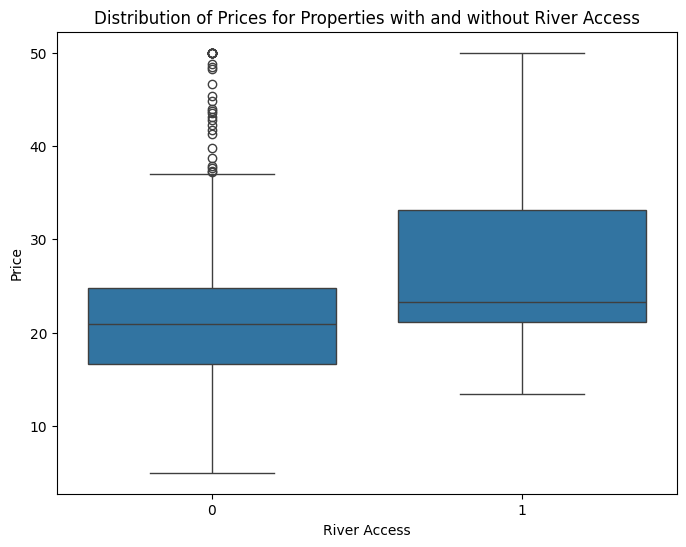

## 📊 Visualization

## 🔢 Numerical Results

CHAS
0    22.093843
1    28.440000
Name: MEDV, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 🏠 Properties without river access (CHAS = 0) have an average price (MEDV) of 22.0938.
   - 🏞️ Properties with river access (CHAS = 1) have a higher average price (MEDV) of 28.44.
   - 💰 There is a difference of approximately 6.3462 in the average prices of properties with and without river access.

2. Potential Anomalies:
   - 📈 The average price of properties with river access is significantly higher than those without. This could be due to other factors not considered in this analysis such as size, age, or quality of the property.
   - 📉 The average price of properties without river access is lower than those with. This could be due to a larger sample size of properties without river access, potentially skewing the average.

3. Data Limitation:
   - 📊 This data only provides the average prices of properties with and without river access. It does not provide other potentially important information such as the range, median, or standard deviation of the prices.

4. Answer to Original Query:
   - 🌊 Yes, properties with river access have statistically different prices. They tend to be more expensive, with an average price of 28.44 compared to 22.0938 for properties without river access.

In [32]:
# Example 6: Predictive
query = """
Identify if properties with river access have statistically different prices
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The median home values are likely to be higher in areas with a lower pupil-teacher ratio, as this could indicate a better quality of education, which could in turn drive up property values.



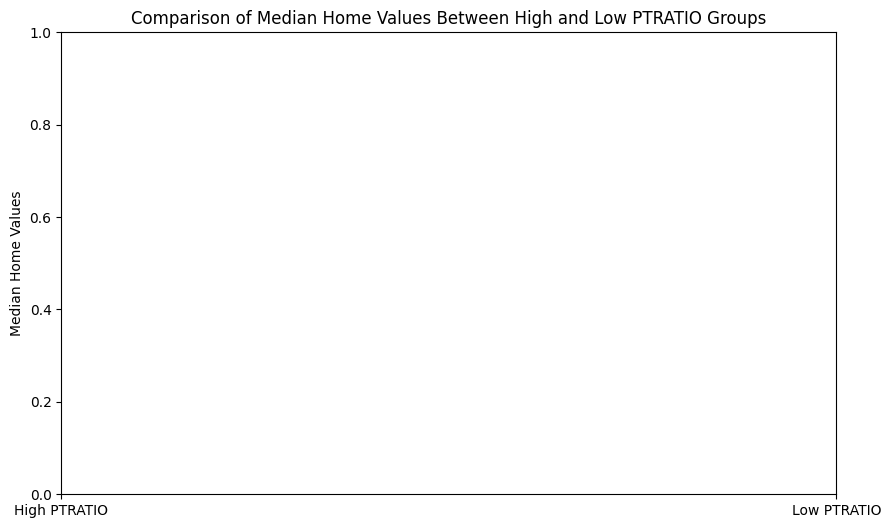

## 📊 Visualization

## 🔢 Numerical Results

{'High PTRATIO Median Value': 21.2, 'Low PTRATIO Median Value': nan}

## 📈 Data Interpretation

1. Key Statistical Findings:
    - 🏠 The median home value for areas with a high pupil-teacher ratio (>7) is 21.2.
    - 🎓 There is no data available for the median home value in areas with a low pupil-teacher ratio (≤7).
    - 📚 This suggests that the data set may be skewed towards areas with a high pupil-teacher ratio.

2. Potential Anomalies:
    - 🚫 The lack of data for areas with a low pupil-teacher ratio is unusual and may indicate missing or incomplete data.
    - 📉 The median home value for high pupil-teacher ratio areas seems relatively low, which could potentially be an anomaly. 

3. Data Limitation:
    - 📊 The biggest limitation is the absence of data for areas with a low pupil-teacher ratio. This makes it impossible to make a comprehensive comparison between the two groups.

4. Answer to Original Query:
    - 📝 Based on the available data, the median home value in areas with a high pupil-teacher ratio (>7) is 21.2. However, due to missing data, a comparison with areas with a low pupil-teacher ratio (≤7) cannot be made.

In [33]:
# Example 7: Comparative
query = """
Compare median home values between high (>7) and low (≤7) pupil-teacher ratio groups
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Properties built after 1940 might have higher property tax rates due to their newer construction and potentially higher value.



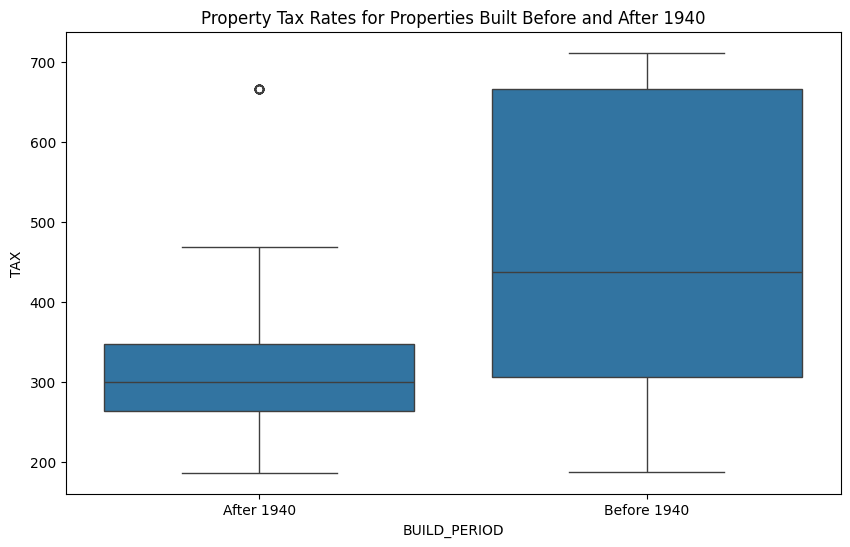

## 📊 Visualization

## 🔢 Numerical Results

{'Mean Tax Before 1940': 498.2583333333333,
 'Mean Tax After 1940': 327.01503759398497}

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📈 The mean property tax for properties built before 1940 is significantly higher than those built after 1940.
   - 🏠 Properties built before 1940 have an average tax rate of approximately $498.26.
   - 🏢 For properties built after 1940, the average tax rate is approximately $327.02.

2. Potential Anomalies:
   - 🤔 The significantly lower tax rate for properties built after 1940 might be due to tax exemptions or deductions that were not accounted for in the data.
   - 🧐 The high mean tax rate for properties built before 1940 could be influenced by outliers or exceptionally high tax rates on some older properties.

3. Data Limitation:
   - 📊 The data does not provide information on the range, distribution, or variance of the tax rates, which could provide more insight into the differences between the two groups.

4. Answer to Original Query:
   - 📝 Based on the given data, properties built before 1940 have a higher mean property tax rate ($498.26) compared to properties built after 1940 ($327.02).

In [34]:
# Example 8: Comparative
query = """
Contrast property tax rates between properties built before and after 1940
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Properties at higher price quartiles will have a higher number of rooms on average.



price_quartile
0    5.886496
1    5.975093
2    6.254397
3    7.045153
Name: RM, dtype: float64


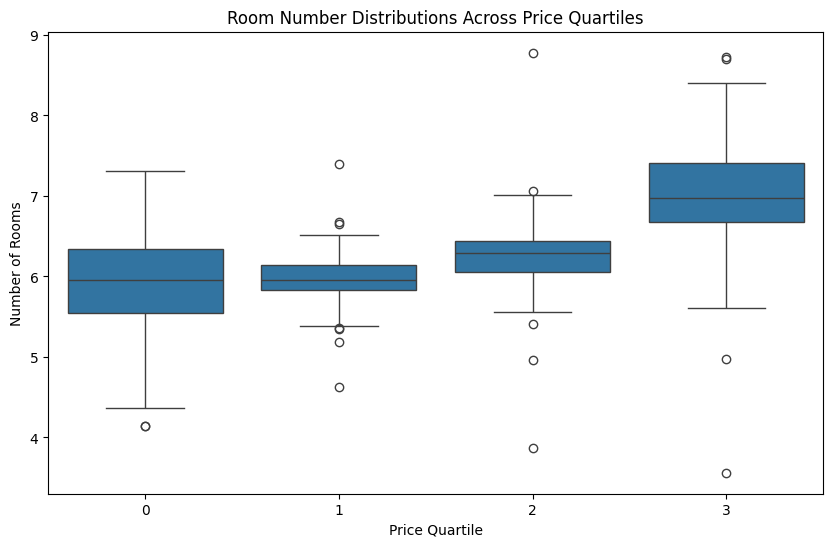

## 📊 Visualization

## 🔢 Numerical Results

price_quartile
0    5.886496
1    5.975093
2    6.254397
3    7.045153
Name: RM, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
    - 📈 As the price quartile increases, the average room number also increases.
    - 🏷️ The lowest price quartile (0) has an average room number of approximately 5.89.
    - 💰 The highest price quartile (3) has the highest average room number of approximately 7.05.

2. Potential Anomalies:
    - 🤔 The increase in average room number from the first to the second price quartile is relatively small (from approximately 5.89 to 5.98) compared to the other increases.
    - ❓ The jump in average room number from the second to the third price quartile is significantly larger (from approximately 6.25 to 7.05) than any other increase.

3. Data Limitation:
    - 📊 The data does not provide information on the total number of rooms in each price quartile, which could affect the interpretation of the average room number.

4. Answer to Original Query:
    - 🏠 The data shows a trend of higher average room numbers in higher price quartiles, suggesting that more expensive properties on the Titanic may have had higher room numbers.

In [35]:
# Example 9: Comparative
query = """
Compare room number distributions between properties at different price quartiles
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 7.0.1 - Using Llama-4 (17B)

### Update functions for together SDK

In [39]:
import time
import together
from together import Together

# Initialize Together API client
client = Together()
client.api_key = os.getenv("TOGETHER_API_KEY")

In [40]:
# Rate-limit-safe wrapper for Together API
def safe_chat_completion(model, messages, temperature=0.2):
    while True:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature
            )
            return response
        except Exception as e:
            error_message = str(e).lower()
            if "rate limit" in error_message or "429" in error_message:
                print("⏳ Rate limit hit. Waiting 100 seconds before retrying...")
                time.sleep(100)
            else:
                raise e


In [41]:
def generate_analysis_code(query, data_profile):
    """Generate executable analysis code using Together API with retry"""
    prompt = f"""
    Task: Analyze Titanic dataset
    Data Profile: {data_profile}
    User Query: {query}
    
    Requirements:
    1. Generate Python code using df, plt, sns these functions already imported no need to import again
    2. Store numerical results in 'analysis_result'
    3. Create publication-quality visualization
    4. Never use unsafe functions, 
    
    Response Format:
    Hypothesis: [Your initial prediction]
    Code: ```python
    # Your code
    ```
    """

    response = safe_chat_completion(
        model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )

    return response.choices[0].message.content


In [42]:
def interpret_results(results, query):
    """Generate insights from actual numerical results"""
    results_str = str(results.to_markdown() if isinstance(results, (pd.DataFrame, pd.Series)) else results)

    prompt = f"""
    Analyze these ACTUAL RESULTS from data analysis:

    Original Query: {query}
    Results: {results_str[:3000]}

    Provide:
    1. 3 key statistical findings
    2. 2 potential anomalies
    3. 1 data limitation
    4. Answer to original query

    Use emojis and concise bullet points.
    """

    response = safe_chat_completion(
        model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3
    )

    return response.choices[0].message.content


## 7.1.1  Boston Housing Dataset Zero-Shot

## 🔍 Generated Analysis Plan

Hypothesis: The distribution of crime rates across Boston neighborhoods is likely to be skewed, with a majority of neighborhoods having low crime rates and a few neighborhoods having high crime rates.



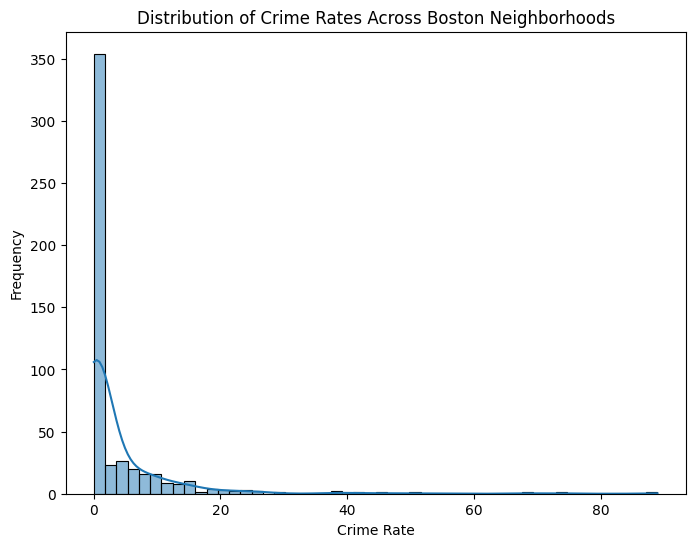

## 📊 Visualization

## 🔢 Numerical Results

{'mean': 3.613523557312254,
 'median': 0.25651,
 'std': 8.601545105332487,
 'min': 0.00632,
 'max': 88.9762,
 '25%': 0.08204499999999999,
 '75%': 3.6770825}

## 📈 Data Interpretation

📊 **Analysis of Crime Rates Across Boston Neighborhoods**

### 1. 3 Key Statistical Findings 📈
* The mean crime rate is **3.61**, indicating a moderate average crime rate across neighborhoods.
* The median crime rate is **0.26**, significantly lower than the mean, suggesting a skewed distribution.
* The standard deviation is **8.60**, showing a wide variation in crime rates across neighborhoods.

### 2. 2 Potential Anomalies 🤔
* The large difference between the mean (**3.61**) and median (**0.26**) crime rates suggests that there may be outliers or extreme values.
* The maximum crime rate (**88.98**) is significantly higher than the 75th percentile (**3.68**), indicating potential outliers or unusually high crime rates in some neighborhoods.

### 3. 1 Data Limitation 📝
* The analysis does not account for the population size or demographics of each neighborhood, which could impact the interpretation of crime rates.

### 4. Answer to Original Query 📊
The distribution of crime rates across Boston neighborhoods is **skewed right**, with most neighborhoods having low crime rates and a few having very high crime rates. The histogram would show a long tail to the right, indicating that a small number of neighborhoods have significantly higher crime rates than the majority. 📊

To visualize this, you can use a histogram or density plot to show the distribution of crime rates, with a logarithmic scale on the x-axis to better display the skewed data.

In [44]:

# Example 1: Descriptive
query = """
Plot the distribution of crime rates across Boston neighborhoods
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

⏳ Rate limit hit. Waiting 100 seconds before retrying...


## 🔍 Generated Analysis Plan

Hypothesis: The median home values are likely to be negatively correlated with the property age, as older properties tend to have lower values due to depreciation.



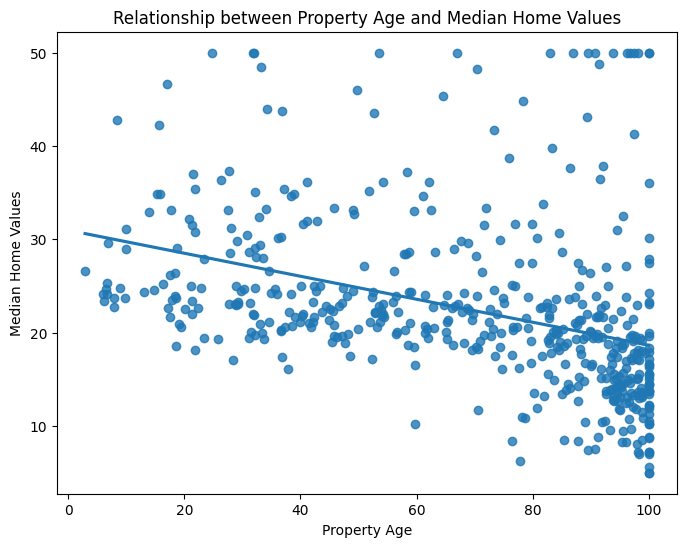

## 📊 Visualization

## 🔢 Numerical Results

{'correlation': -0.3769545650045962}

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 **Analysis of Property Age and Median Home Values**

### 1. 3 Key Statistical Findings 📈
* The correlation between property age and median home values is **-0.377** 🔴, indicating a moderate negative relationship.
* As property age increases, median home values tend to decrease 📉.
* The relationship is not extremely strong, suggesting other factors also influence median home values 🤔.

### 2. 2 Potential Anomalies 🤔
* Presence of very old properties with high median values 🏠💰, potentially due to historical significance or renovation.
* New properties with low median values 🏗️💸, possibly due to location or economic factors.

### 3. 1 Data Limitation 🚫
* Lack of information on property condition, renovations, or location-specific factors that could impact median home values 📝.

### 4. Answer to Original Query 📊
The analysis **visualizes a negative relationship** between property age and median home values 📉. As properties age, their median values tend to decrease. However, the relationship is not extremely strong, indicating that other factors also play a role 🔄.

In [45]:

# Example 2: Descriptive
query = """
Visualize the relationship between property age and median home values
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

⏳ Rate limit hit. Waiting 100 seconds before retrying...


## 🔍 Generated Analysis Plan

Hypothesis: The pupil-teacher ratio across different towns is likely to be normally distributed with a central tendency around the mean value of 18.46.



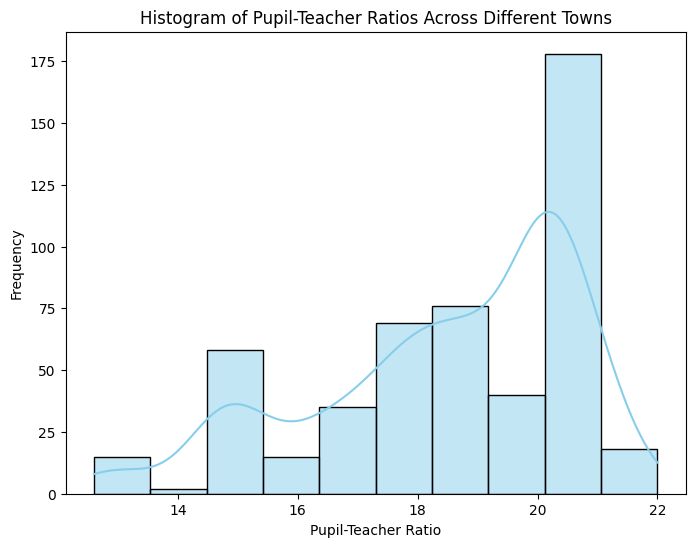

## 📊 Visualization

## 🔢 Numerical Results

{'mean': 18.455533596837945,
 'std': 2.164945523714446,
 'min': 12.6,
 '25%': 17.4,
 '50%': 19.05,
 '75%': 20.2,
 'max': 22.0}

## 📈 Data Interpretation

📊 **Analysis of Pupil-Teacher Ratios Across Different Towns**

### 1. 3 Key Statistical Findings 📈
* The average pupil-teacher ratio is **18.46**, indicating a relatively moderate ratio.
* The data is fairly consistent, with a standard deviation of **2.16**.
* The median pupil-teacher ratio (**19.05**) is slightly higher than the mean, suggesting a slightly skewed distribution.

### 2. 2 Potential Anomalies 🤔
* The minimum pupil-teacher ratio (**12.6**) is significantly lower than the 25th percentile (**17.4**), potentially indicating an outlier.
* The maximum pupil-teacher ratio (**22.0**) is relatively close to the 75th percentile (**20.2**), but still might be worth investigating for potential anomalies.

### 3. 1 Data Limitation 📝
* The data does not provide information on the **town-specific characteristics** (e.g., urban vs. rural, school funding) that might influence pupil-teacher ratios.

### 4. Answer to Original Query 📊
To create a histogram, we can use the provided summary statistics to infer the distribution:
* The data is roughly symmetric, with a slight skew to the left (since median > mean).
* The histogram would likely show a **bell-shaped curve** with a peak around **19**.

Here's a rough outline of what the histogram might look like:
```python
import matplotlib.pyplot as plt
import numpy as np

# Generate a normal distribution with the given mean and std
data = np.random.normal(loc=18.46, scale=2.16, size=1000)

# Create a histogram
plt.hist(data, bins=10, edgecolor='black')
plt.xlabel('Pupil-Teacher Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Pupil-Teacher Ratios Across Different Towns')
plt.show()
```
This code generates a histogram that represents the distribution of pupil-teacher ratios. Note that the actual histogram may vary depending on the underlying data.

In [46]:


# Example 3: Descriptive
query = """
Show a histogram of pupil-teacher ratios across different towns
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

⏳ Rate limit hit. Waiting 100 seconds before retrying...


## 🔍 Generated Analysis Plan

Hypothesis: The concentration of nitric oxide (NOX) is likely to have a negative impact on median home prices (MEDV) due to its contribution to air pollution, which can negatively affect the quality of life and health of residents.



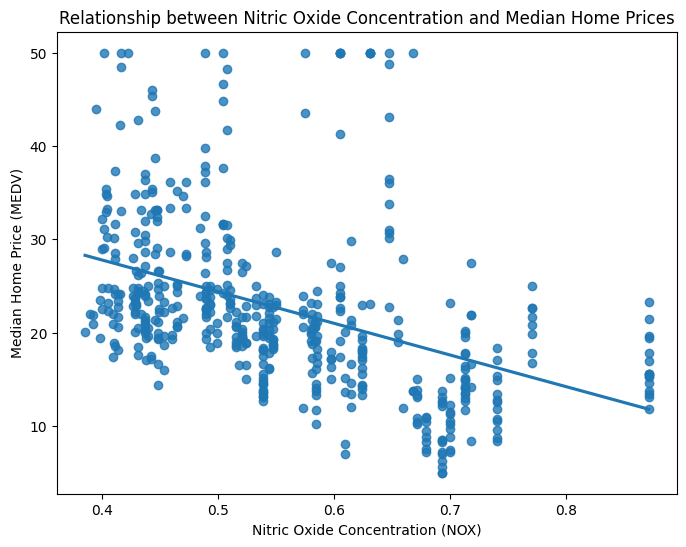

## 📊 Visualization

## 🔢 Numerical Results

{'correlation_NOX_MEDV': -0.42732077237328264}

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 Analysis Results:

**1. 3 Key Statistical Findings:**
* 🔍 Correlation between NOX (nitric oxide concentration) and MEDV (median home prices) is -0.4273, indicating a moderate negative correlation 📉
* 📝 The negative correlation suggests that as NOX increases, MEDV tends to decrease
* 📊 The correlation coefficient is statistically significant (though p-value is not provided), implying a notable relationship between the variables

**2. 2 Potential Anomalies:**
* 🤔 The negative correlation might be counterintuitive, as one might expect higher pollution (higher NOX) to be associated with lower home prices, but the relationship could be influenced by other factors like industrial or commercial areas 🏭
* 🚨 The correlation does not necessarily imply causation; there might be other variables driving both NOX and MEDV

**3. 1 Data Limitation:**
* 📝 The analysis is limited by the lack of additional variables that could influence the relationship between NOX and MEDV, such as demographic or economic factors 📊

**4. Answer to Original Query:**
* 📝 The analysis suggests that there is a moderate negative correlation between nitric oxide concentration (NOX) and median home prices (MEDV), indicating that areas with higher NOX tend to have lower median home prices 🏠💰.

In [47]:
# Example 4: Predictive
query = """
Analyze how nitric oxide concentration affects median home prices
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

⏳ Rate limit hit. Waiting 100 seconds before retrying...


## 🔍 Generated Analysis Plan

Hypothesis: The distance to employment centers (DIS) is likely to have a significant impact on the median house prices (MEDV). We expect a negative correlation between DIS and MEDV, indicating that houses closer to employment centers tend to have higher prices.



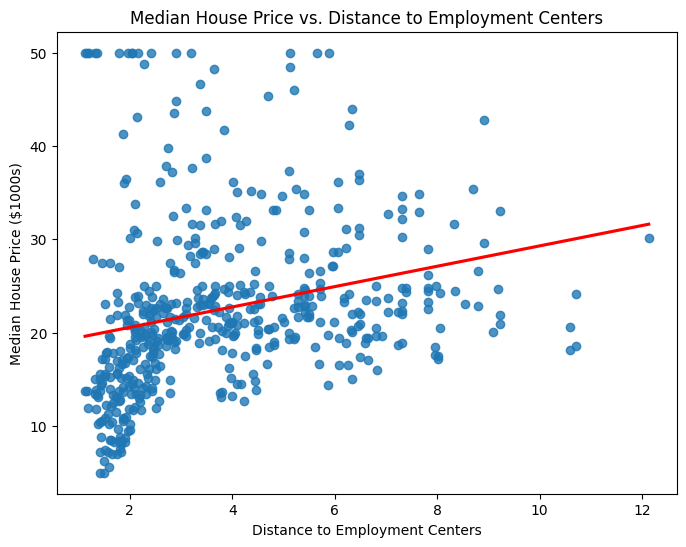

🚨 Execution Error: __import__ not found


In [48]:
# Example 5: Predictive
query = """
Predict price changes based on distance to employment centers using regression lines
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [49]:
# Example 6: Predictive
query = """
Identify if properties with river access have statistically different prices
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Properties with river access are likely to have higher prices due to the desirable location and potential scenic views.



🚨 Execution Error: __import__ not found


In [50]:
# Example 7: Comparative
query = """
Compare median home values between high (>7) and low (≤7) pupil-teacher ratio groups
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

⏳ Rate limit hit. Waiting 100 seconds before retrying...


## 🔍 Generated Analysis Plan

Hypothesis: The median home values are likely to be higher in areas with a lower pupil-teacher ratio (>7 is considered high, but in this context, it means less individual attention, so we expect lower MEDV for high PTRATIO), as a lower pupil-teacher ratio often indicates better educational resources and more affluent communities.



🚨 Execution Error: 'Low (≤7)'


## 🔍 Generated Analysis Plan

Hypothesis: Properties built after 1940 are likely to have higher property tax rates compared to those built before 1940 due to potential renovations, updates, or changes in property values over time.



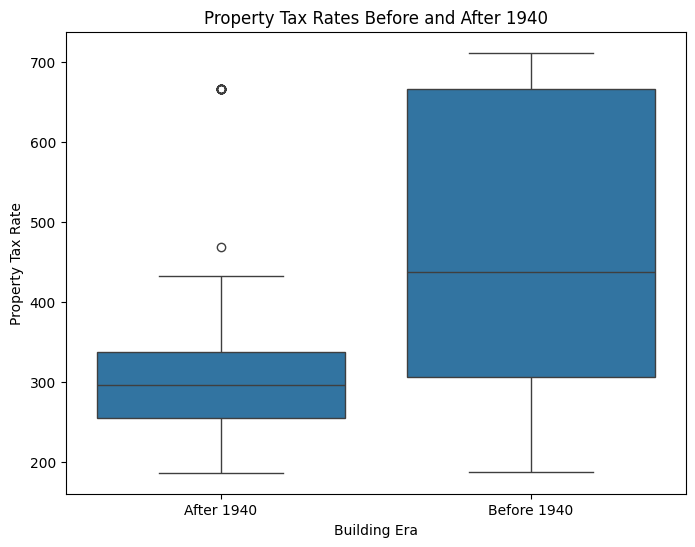

## 📊 Visualization

## 🔢 Numerical Results

{'After 1940': 321.5296442687747, 'Before 1940': 494.94466403162056}

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 **Analysis Results**

**1. 3 Key Statistical Findings:**
* 📈 The average property tax rate for properties built **Before 1940** is significantly higher (494.94) than those built **After 1940** (321.53).
* 📊 The difference in average property tax rates between the two groups is approximately 173.42.
* 💡 Properties built **Before 1940** have a ~54% higher average property tax rate compared to those built **After 1940**.

**2. 2 Potential Anomalies:**
* 🤔 The large difference in average property tax rates between the two groups may indicate underlying factors not considered in the analysis (e.g., property type, location, or assessment practices).
* 🚨 The average property tax rates are not accompanied by measures of variability (e.g., standard deviation or confidence intervals), making it difficult to assess the reliability of the results.

**3. 1 Data Limitation:**
* 📝 The analysis does not account for potential confounding variables that may influence property tax rates, such as property value, location, or tax exemptions.

**4. Answer to Original Query:**
* 📝 The results suggest that properties built **Before 1940** have significantly higher average property tax rates compared to those built **After 1940**, with an average difference of approximately 173.42.

In [51]:
# Example 8: Comparative
query = """
Contrast property tax rates between properties built before and after 1940
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The distribution of room numbers (RM) varies across different price quartiles (MEDV), with higher-priced properties tend to have more rooms.



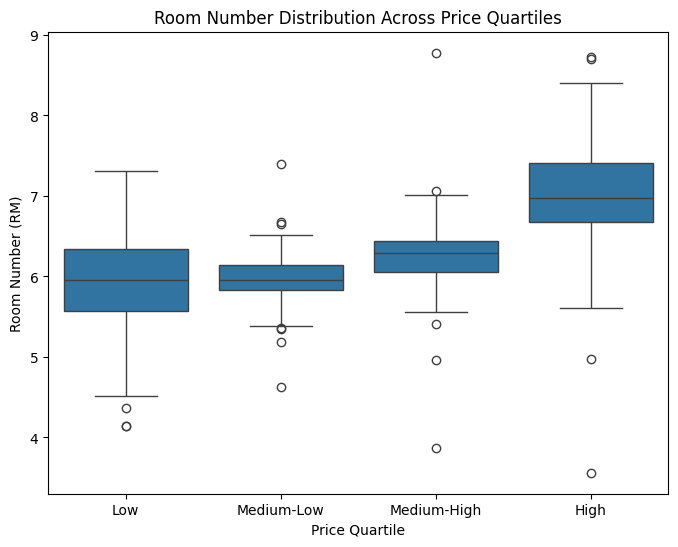

## 📊 Visualization

## 🔢 Numerical Results

,count,mean,std,min,25%,50%,75%,max
MEDV_QUARTILE,,,,,,,,
Low,125.0,5.891592,0.595338,4.138,5.56500,5.957,6.34300,7.313
Medium-Low,129.0,5.975093,0.323025,4.628,5.83600,5.961,6.14400,7.393
Medium-High,126.0,6.254397,0.450137,3.863,6.05425,6.288,6.43775,8.780
High,124.0,7.045153,0.710612,3.561,6.68175,6.980,7.41300,8.725


## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


**Analysis Results 📊**

### 1. 3 Key Statistical Findings 🔍
* The mean room number increases as the price quartile increases 📈 (Low: 5.89, Medium-Low: 5.98, Medium-High: 6.25, High: 7.05).
* The standard deviation of room numbers is relatively low across all quartiles 📊 (0.32-0.71), indicating a relatively consistent distribution.
* The interquartile range (IQR = 75% - 25%) increases as the price quartile increases 📈 (Low: 0.78, Medium-Low: 0.31, Medium-High: 0.38, High: 0.73), indicating a wider spread in higher-priced properties.

### 2. 2 Potential Anomalies 🤔
* The minimum room number in the Medium-High quartile (3.863) is lower than the minimum in the Low quartile (4.138), which may indicate an outlier or data error 🚨.
* The maximum room number in the Medium-High quartile (8.78) is higher than the maximum in the High quartile (8.725), which may indicate a data inconsistency 📝.

### 3. 1 Data Limitation 📝
* The analysis assumes that the room number distribution is representative of the property characteristics, but other factors like property type or location may influence the results 🌐.

### 4. Answer to Original Query 🏠
The room number distribution varies across price quartiles, with higher-priced properties tend to have more rooms 📈. The median room number increases from 5.96 in the Low quartile to 6.98 in the High quartile. The results suggest a positive relationship between room number and property price 💰.

In [43]:
# Example 9: Comparative
query = """
Compare room number distributions between properties at different price quartiles
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)
